Import the Required Libraries

In [37]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

UsageError: Line magic function `%` not found.


Read the Data into our IDE
Our data is a text file (.txt) of English-German sentence pairs.

In [39]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

split the text into English-German pairs separated by ‘\n’.

In [6]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [40]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
len(deu_eng)

195060

The actual data contains over 195,060 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model

In [42]:
deu_eng = deu_eng[:50000,:]

In [43]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['This is all your fault.', 'Das ist alles deine Schuld!'],
       ['This is an ancient law.', 'Das ist ein altes Gesetz.'],
       ['This is an improvement.', 'Das ist eine Verbesserung.']],
      dtype='<U537')

Text Pre-Processing 

In [44]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [45]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [46]:
deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['this is all your fault', 'das ist alles deine schuld'],
       ['this is an ancient law', 'das ist ein altes gesetz'],
       ['this is an improvement', 'das ist eine verbesserung']],
      dtype='<U537')

Text to Sequence Conversion

In [50]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))
    


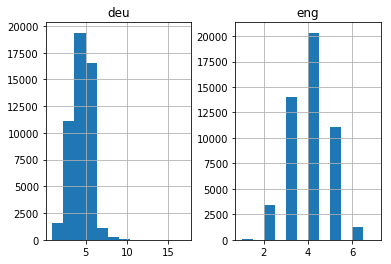

In [52]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 12)
plt.show()

In [53]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [54]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

English Vocabulary Size: 6391
Deutch Vocabulary Size: 10731


In [55]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

Model Building.. 
We will encode German sentences as the input sequences and English sentences as the target sequences. This has to be done for both the train and test datasets.

In [56]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

For the encoder, we will use an embedding layer and an LSTM layer
For the decoder, we will use another LSTM layer followed by a dense layer

In [57]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [58]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [60]:
filename = 'model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=5, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 271s 8ms/step - loss: 2.9437 - val_loss: 3.0570

Epoch 00001: val_loss improved from inf to 3.05699, saving model to model.h1
Epoch 2/5
32000/32000 [==============================] - 269s 8ms/step - loss: 2.8031 - val_loss: 2.7462

Epoch 00002: val_loss improved from 3.05699 to 2.74620, saving model to model.h1
Epoch 3/5
32000/32000 [==============================] - 266s 8ms/step - loss: 2.6171 - val_loss: 2.6118

Epoch 00003: val_loss improved from 2.74620 to 2.61179, saving model to model.h1
Epoch 4/5
32000/32000 [==============================] - 278s 9ms/step - loss: 2.4726 - val_loss: 2.5021

Epoch 00004: val_loss improved from 2.61179 to 2.50206, saving model to model.h1
Epoch 5/5
32000/32000 [==============================] - 272s 8ms/step - loss: 2.3295 - val_loss: 2.4049

Epoch 00005: val_loss improved from 2.50206 to 2.40489, saving model to model.h1


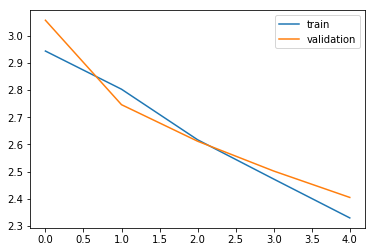

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [62]:
model = load_model('model.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [63]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [64]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [65]:
pd.set_option('display.max_colwidth', 200)
pred_df.head(15)

,actual,predicted
0,hows your job going,how me a
1,i love him,i like to
2,mary likes you,tom be
3,i met a friend,i have a
4,tom doesnt buy bread,tom is a
5,i cant come tomorrow,i dont to a
6,youll love australia,i you to
7,ive got a great idea,i have a
8,do you like candy,you like
9,no one encouraged her,dont it me
